### Import libararies

In [49]:
import torch
import pyrealsense2 as rs
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Configure the model for inference

In [50]:
weights = "cartons_palletM_best_200e_16b.pt"
# weights = "cartonM_50e_16b.pt"

bag_file = "20230219_161143.bag"

# custom model in weights folder
model = torch.hub.load("../yolov5-7.0", "custom", path=weights, source="local")

# set model parameters
model.conf = 0.25  # confidence threshold (0-1)
model.iou = 0.25  
# model.classes = None  # filter by class: --class 0, or --class 0 2 3

YOLOv5 🚀 2022-11-22 Python-3.9.16 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# Load the color and depth images

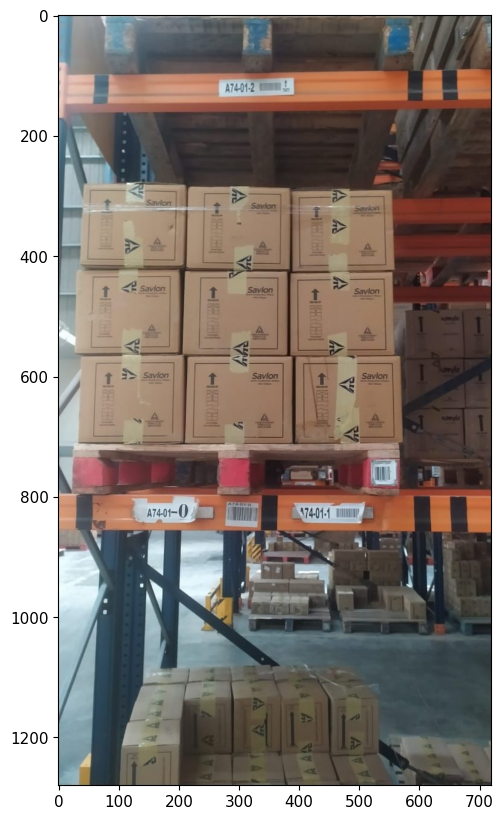

In [51]:
# input_image = cv2.imread("images/9/input.png")
input_image = cv2.imread("test_images/itc-1.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

original_image = input_image.copy()

# show image
plt.figure(figsize=(10, 10))
plt.imshow(input_image)
plt.show()

### Perform inference

{0: 'Carton', 1: 'pallets'}


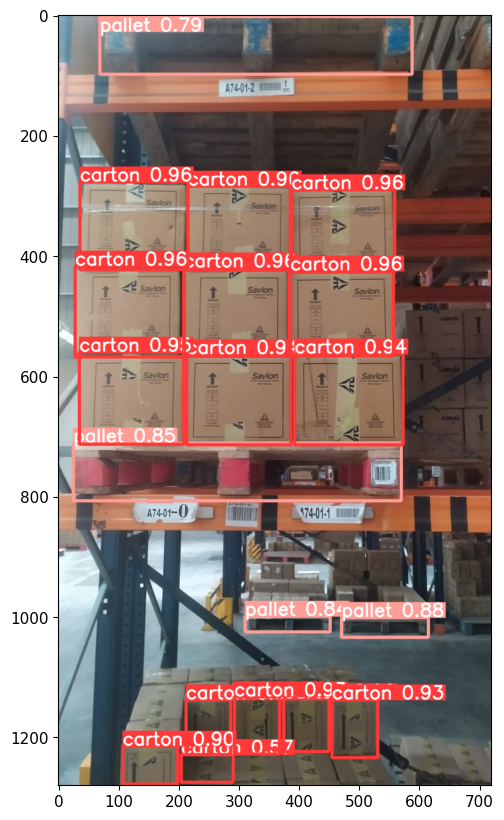

In [52]:
# Run inference
results = model(input_image)

print(results.names)

results.names={0: 'carton', 1: 'pallet'}

output_image = results.render()[0]

# show image
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.show()

### Identify all the cartons that are on the pallet

tensor([[2.58128e+01, 7.11895e+02, 5.69133e+02, 8.07238e+02, 8.54565e-01, 1.00000e+00],
        [3.10797e+02, 9.99829e+02, 4.51498e+02, 1.02543e+03, 8.44907e-01, 1.00000e+00],
        [4.70037e+02, 1.00162e+03, 6.14528e+02, 1.03410e+03, 8.80826e-01, 1.00000e+00]])


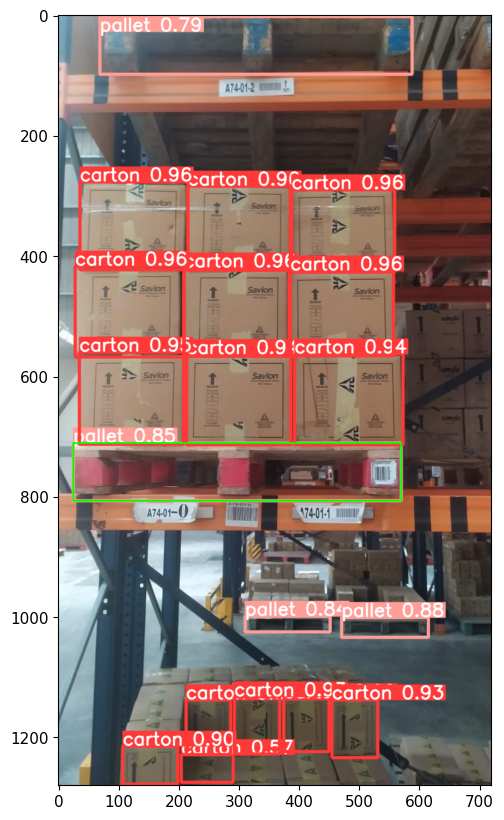

In [53]:
pallet_image = original_image.copy()
pallet_boxes = results.xyxy[0][results.pred[0][:, 5] == 1]

# select only the pallet with the largest area
pallet_boxes = pallet_boxes[np.argsort(pallet_boxes[:, 2] * pallet_boxes[:, 3])]
pallet_boxes = pallet_boxes[1:]

print(pallet_boxes)

# plot the pallet on the image
pallet_image = cv2.rectangle(input_image, (int(pallet_boxes[0, 0]), int(pallet_boxes[0, 1])), (int(pallet_boxes[0, 2]), int(pallet_boxes[0, 3])), (0, 255, 0), 2)

# show image
plt.figure(figsize=(10, 10))
plt.imshow(pallet_image)
plt.show()

### Count the number of cartons on the pallet

tensor(15.81284) tensor(711.89514) tensor(579.13293) tensor(807.23792)
Carton is outside the pallet
Carton is outside the pallet
Carton is outside the pallet
Carton is outside the pallet
Carton is outside the pallet
Carton is outside the pallet


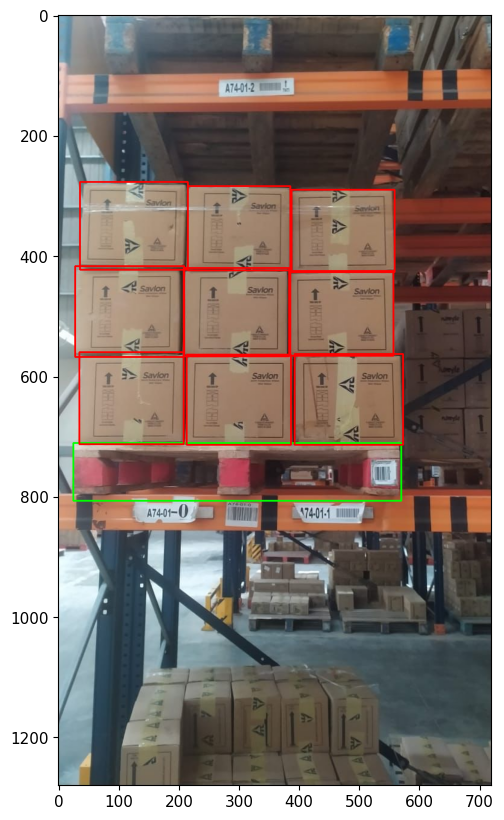

In [54]:
#### Check cartons which are inside the pallet
carton_box_image = original_image.copy()

carton_boxes = results.xyxy[0][results.pred[0][:, 5] == 0]

# pallet coordinates
# x1, y1, x2, y2
pallet_x1 = pallet_boxes[0, 0] - 10
pallet_y1 = pallet_boxes[0, 1]
pallet_x2 = pallet_boxes[0, 2] + 10
pallet_y2 = pallet_boxes[0, 3]

print(pallet_x1, pallet_y1, pallet_x2, pallet_y2)

# plot the pallet on the image
carton_box_image = cv2.rectangle(carton_box_image, (int(pallet_boxes[0, 0]), int(pallet_boxes[0, 1])), (int(pallet_boxes[0, 2]), int(pallet_boxes[0, 3])), (0, 255, 0), 2)


cartons_in_pallet = []

for carton_box in carton_boxes:
    # carton coordinates
    # x1, y1, x2, y2
    carton_x1 = carton_box[0]
    carton_y1 = carton_box[1]
    carton_x2 = carton_box[2]
    carton_y2 = carton_box[3]

    # check if carton is inside the pallet
    if carton_x1 > pallet_x1 and carton_x2 < pallet_x2 and carton_y2 < pallet_y2:
        cartons_in_pallet.append(carton_box)
    else:
        print("Carton is outside the pallet")

# plot the cartons on the image
for carton_box in cartons_in_pallet:
    carton_box_image = cv2.rectangle(carton_box_image, (int(carton_box[0]), int(carton_box[1])), (int(carton_box[2]), int(carton_box[3])), (255, 0, 0), 2)

# show image
plt.figure(figsize=(10, 10))
plt.imshow(carton_box_image)
plt.show()
